#### Global explainability
- Overall model behavior
- Doesn't explain individual instances

#### Local explainability
- Explains prediction for specific data point
- Crucial for sensitive applications

In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the dataset
df = pd.read_csv("heart.csv")

columns_to_keep = ['age', 'sex', 'cp', 'trestbps', 'restecg', 'thal', 'target']
df = df[columns_to_keep]
print(df.head())

   age  sex  cp  trestbps  restecg  thal  target
0   52    1   0       125        1     3       0
1   53    1   0       140        0     3       0
2   70    1   0       145        1     3       0
3   61    1   0       148        1     3       0
4   62    0   0       138        1     2       0


In [3]:
# Define features and target
X = df.drop('target', axis=1)
y = df['target']

# Standardize the features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# Initialize and train the KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)  
knn_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_clf.predict(X_test)

### Local Explainability with SHAP

In [4]:
import shap

explainer = shap.KernelExplainer(knn_clf.predict_proba, shap.kmeans(X, 10))
test_instance = X.iloc[0, :]
shap_values = explainer.shap_values(test_instance)

print(shap_values.shape)

(6, 2)


### SHAP Waterfall plots
- Shows how features increase or decrease model's prediction

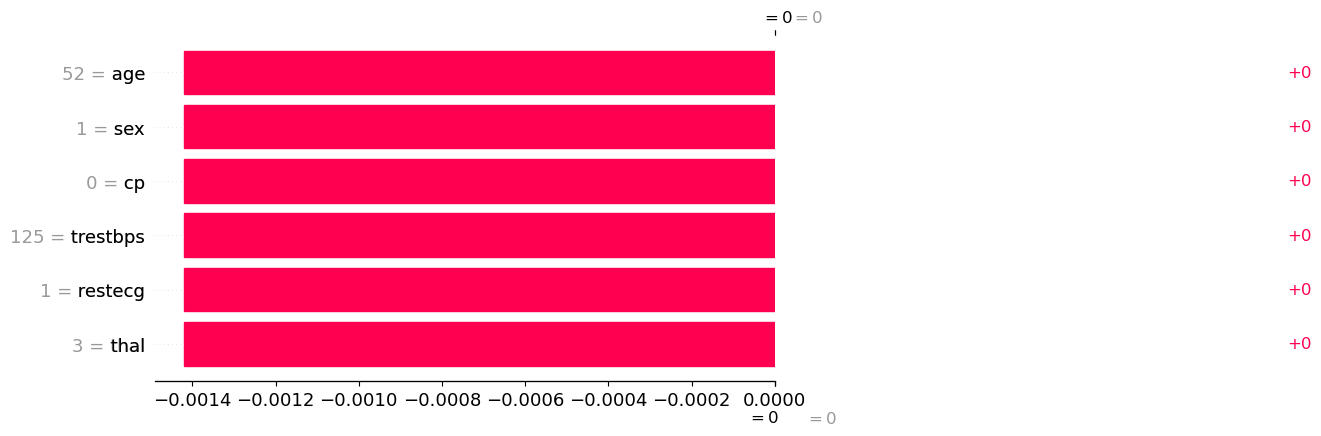

In [5]:
shap.waterfall_plot(
    shap.Explanation(    
        values=shap_values[:,1],    
        base_values=explainer.expected_value[1],    
        data=test_instance,    
        feature_names=X.columns
    )
)

In [6]:
# Using adult.csv to build a KNN model

# Load the dataset
df1 = pd.read_csv("adult.csv")

columns_to_keep1 = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income']
df1 = df1[columns_to_keep1]
print(df1.head())

   age  educational-num  capital-gain  capital-loss  hours-per-week income
0   25                7             0             0              40  <=50K
1   38                9             0             0              50  <=50K
2   28               12             0             0              40   >50K
3   44               10          7688             0              40   >50K
4   18               10             0             0              30  <=50K


In [7]:
# Define features and target
X1 = df1.drop('income', axis=1)
y1 = df1['income']

# Standardize the features 
scaler = StandardScaler()
X_scaled1 = scaler.fit_transform(X1)

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled1, y1, test_size=0.2, random_state=1)

# Initialize and train the KNN classifier
model = KNeighborsClassifier(n_neighbors=3)  
model.fit(X_train1, y_train1)

# Predict and evaluate
y_pred = model.predict(X_test1)

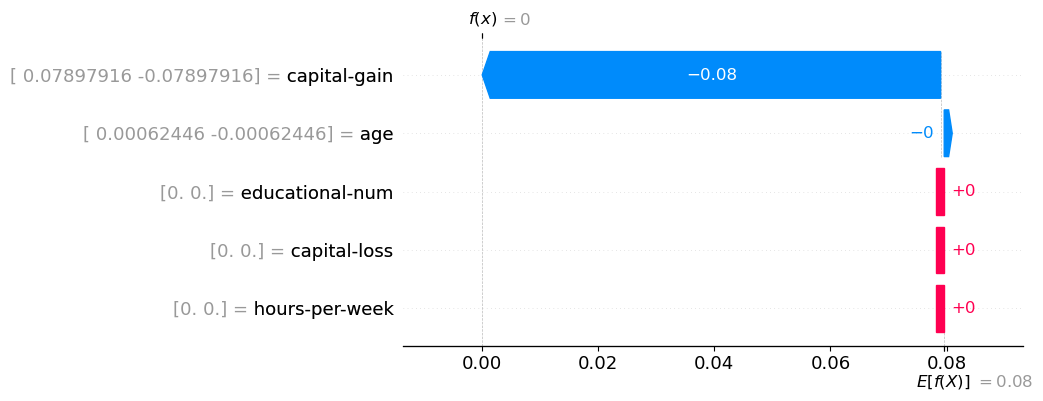

In [8]:
# training ver 1

# Create the SHAP explainer
explainer = shap.KernelExplainer(model.predict_proba, shap.kmeans(X1, 10))

# Compute SHAP values for the first instance in the test dataset
shap_values = explainer.shap_values(X1.iloc[0,:])

# Plot the SHAP values using a waterfall plot
shap.waterfall_plot(shap.Explanation(values=shap_values[:,1], 
                    base_values=explainer.expected_value[1], 
                    data=shap_values, 
                    feature_names=X1.columns))

### LIME 
- Local Interpretable Model-Agnostic Explanations
- Explains predictions of complex models
- Works on individual instancesAgnostic to model type

### LIME Explainers
- Tailored to different kinds of data
- Generates perturbations around a sample
- Sees effect on model's output
- Constructs simpler model for explanation

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

df2 = pd.read_csv('admission_data.csv')

# Handle missing values
imputer = SimpleImputer(strategy="mean")
df2[['LOR']] = imputer.fit_transform(df2[['LOR']])

# Define features and target for classification
X2 = df2.drop(['Accept'], axis=1)
y2 = df2['Accept']

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

# Initialize and train classifier (logistic regression)
classifier = LogisticRegression()
classifier.fit(X_train_scaled2, y_train2)

LogisticRegression()

In [10]:
# Define features and target for regression
Xr = df2.drop(['Chance of Admit'], axis=1)
yr = df2['Chance of Admit']

# Train-test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)

# Feature scaling
Xr_train_scaled = scaler.fit_transform(Xr_train)
Xr_test_scaled = scaler.transform(Xr_test)

# Initialize and train regressor (linear regression)
regressor = LinearRegression()
regressor.fit(Xr_train_scaled, yr_train)

LinearRegression()

### Creating Tabular Explainer

#### Classification

In [11]:
from lime.lime_tabular import LimeTabularExplainer

instance = X2.iloc[1,:]

explainer_class = LimeTabularExplainer(X2.values,  
                                       feature_names=X2.columns,  
                                       mode='classification')

explanation_class = explainer_class.explain_instance(instance.values, classifier.predict_proba)

#### Regression

In [12]:
instance1 = Xr.iloc[1,:]

explainer_reg = LimeTabularExplainer(Xr.values,
                                     feature_names=Xr.columns,  
                                     mode='regression')

explanation_reg = explainer_reg.explain_instance(instance1.values, regressor.predict)

### Visualizing Explaination

#### Regression

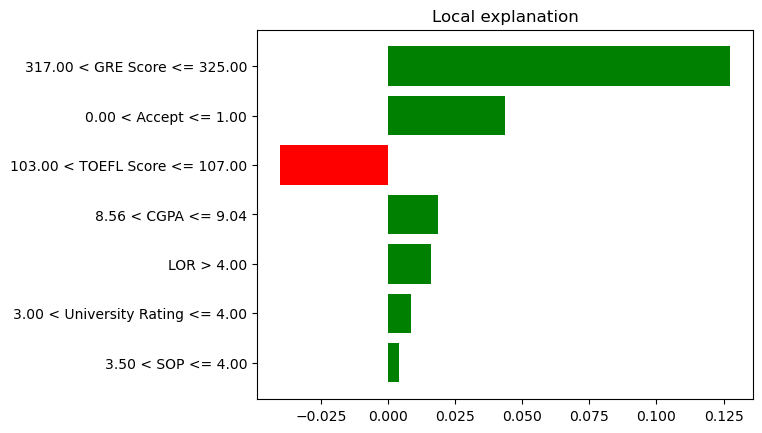

In [13]:
import matplotlib.pyplot as plt

explanation_reg.as_pyplot_figure() 
plt.show()

#### Classification

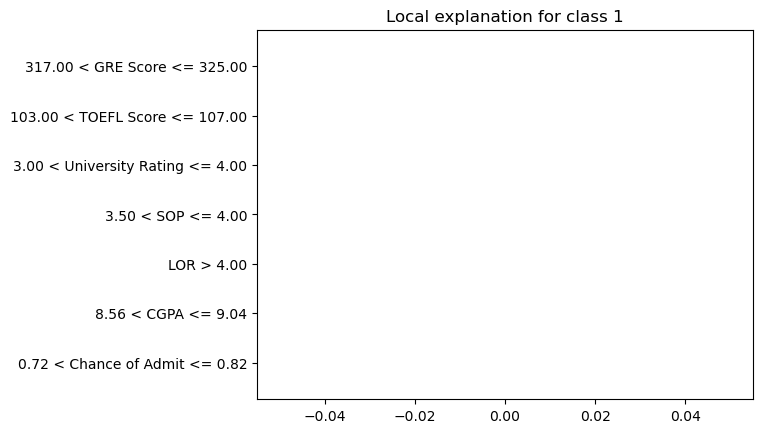

In [14]:
explanation_class.as_pyplot_figure()
plt.show()

#### Using 'heart.csv'

In [15]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Load the dataset
heart = pd.read_csv("heart.csv")

columns_to_keep = ['age', 'sex', 'cp', 'trestbps', 'restecg', 'thal', 'target']
heart = heart[columns_to_keep]
print(heart.head())

# -------------------------------
# KNN CLASSIFIER
# -------------------------------

# Define features and target for classification
X_knn_clf = heart.drop('target', axis=1)
y_knn_clf = heart['target']

# Split data
X_train_knn_clf, X_test_knn_clf, y_train_knn_clf, y_test_knn_clf = train_test_split(X_knn_clf, y_knn_clf, test_size=0.2, random_state=1)

# Scale features
scaler_knn_clf = StandardScaler()
X_train_knn_clf_scaled = scaler_knn_clf.fit_transform(X_train_knn_clf)
X_test_knn_clf_scaled = scaler_knn_clf.transform(X_test_knn_clf)

# Initialize and train KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_knn_clf_scaled, y_train_knn_clf)

   age  sex  cp  trestbps  restecg  thal  target
0   52    1   0       125        1     3       0
1   53    1   0       140        0     3       0
2   70    1   0       145        1     3       0
3   61    1   0       148        1     3       0
4   62    0   0       138        1     2       0


KNeighborsClassifier(n_neighbors=3)

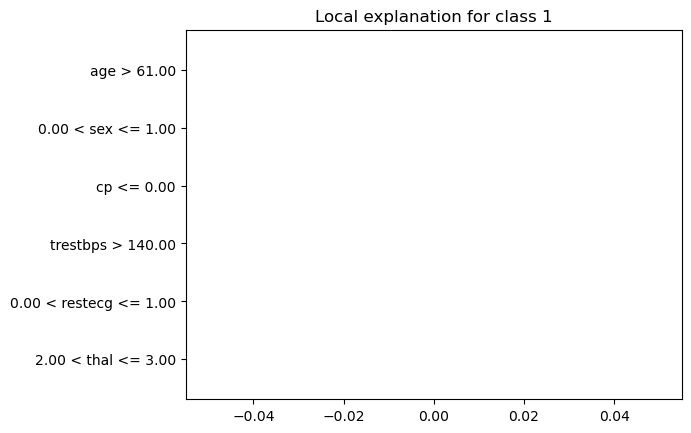

In [16]:
# training ver 2

from lime.lime_tabular import LimeTabularExplainer

sample_data_point = X_knn_clf.iloc[2, :]

# Create the explainer
explainer = LimeTabularExplainer(X_knn_clf.values,  
                                       feature_names=X_knn_clf.columns,  
                                       mode='classification')

# Generate the explanation
exp = explainer.explain_instance(sample_data_point.values, knn_clf.predict_proba)

# Display the explanation
exp.as_pyplot_figure()
plt.show()

In [17]:
# -------------------------------
# KNN REGRESSOR 
# -------------------------------

# Define features and target for regression
X_knn_reg = heart.drop('target', axis=1)
y_knn_reg = heart['target']  # Still binary but for regression demo

# Split data
X_train_knn_reg, X_test_knn_reg, y_train_knn_reg, y_test_knn_reg = train_test_split(X_knn_reg, y_knn_reg, test_size=0.2, random_state=1)

# Scale features
scaler_knn_reg = StandardScaler()
X_train_knn_reg_scaled = scaler_knn_reg.fit_transform(X_train_knn_reg)
X_test_knn_reg_scaled = scaler_knn_reg.transform(X_test_knn_reg)

# Initialize and train KNN Regressor
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train_knn_reg_scaled, y_train_knn_reg)

KNeighborsRegressor(n_neighbors=3)

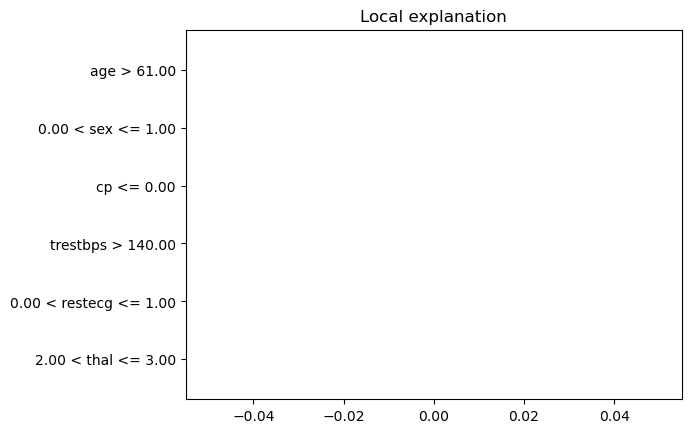

In [18]:
# training ver 3

from lime.lime_tabular import LimeTabularExplainer

sample_data_point = X_knn_reg.iloc[2, :]

# Create the explainer
explainer = LimeTabularExplainer(X_knn_reg.values, feature_names=X_knn_reg.columns, mode='regression')

# Generate the explanation
exp = explainer.explain_instance(sample_data_point.values, knn_regressor.predict)

# Display the explanation
exp.as_pyplot_figure()
plt.show()

In [19]:
# training ver 4

# from lime.lime_text import LimeTextExplainer

# text_instance = "Amazing battery life and the camera quality is perfect! I highly recommend this smartphone."

# # Create a LIME text explainer
# explainer = LimeTextExplainer()

# # Generate the explanation
# exp = explainer.explain_instance(text_instance, model_predict)

# # Display the explanation
# exp.as_pyplot_figure()
# plt.show()

In [20]:
# training ver 5

# from lime.lime_image import LimeImageExplainer
# np.random.seed(10)

# # Create a LIME explainer
# explainer = LimeImageExplainer()

# # Generate the explanation
# explanation = explainer.explain_instance(image, model_predict, hide_color=0, num_samples=50)

# # Display the explanation
# temp, _ = explanation.get_image_and_mask(explanation.top_labels[0], hide_rest=True)
# plt.imshow(temp)
# plt.title('LIME Explanation')
# plt.axis('off')
# plt.show()